In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import LocalOutlierFactor
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Load your dataset
# Upload your CSV file to Colab first
from google.colab import files
uploaded = files.upload()

# Read the dataset
import io
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

# Display information
display("✅ Dataset loaded successfully!")
display(f"📊 Dataset shape: {df.shape}")
display(df.head())


Saving rwandan_household_energy.csv to rwandan_household_energy (1).csv


'✅ Dataset loaded successfully!'

'📊 Dataset shape: (11000, 13)'

,Household_ID,Appliance,Power_Watts,Usage_Hours_Daily,Quantity,Usage_Days_Monthly,Region,Income_Level,Household_Size,Total_kWh_Monthly,Tariff_Bracket,Estimated_Bill_RWF,Month
0,HH00001,Laptop,57,7.1,2,27,Eastern,High,1,21.85,21-50 kWh,6773.50,March
1,HH00002,Iron,1041,4.4,3,23,Eastern,High,6,316.05,50+ kWh,116622.45,May
2,HH00003,Washing Machine,562,5.3,1,28,Eastern,Low,6,83.40,50+ kWh,30774.60,May
3,HH00004,Water Heater,1804,3.5,1,30,Southern,High,7,189.42,50+ kWh,69895.98,October
4,HH00005,Radio,44,6.7,1,25,Kigali,High,5,7.37,0-20 kWh,655.93,August


##  DATA EXPLORATION

**Dataset info:** 11000 rows × 13 columns

###  Basic Statistics

,Total_kWh_Monthly,Household_Size
count,11000.000000,11000.000000
mean,152.120725,4.521455
std,256.482563,2.303441
min,0.100000,1.000000
25%,6.480000,3.000000
50%,28.585000,5.000000
75%,199.307500,7.000000
max,2689.200000,8.000000


###  Missing Values

,Missing_Count
Household_ID,0
Appliance,0
Power_Watts,0
Usage_Hours_Daily,0
Quantity,0
Usage_Days_Monthly,0
Region,0
Income_Level,0
Household_Size,0
Total_kWh_Monthly,0


###  Unique Values in Categorical Columns

- **Regions:** Eastern, Southern, Kigali, Northern, Western

- **Income Levels:** High, Low, Medium

- **Tariff Brackets:** 21-50 kWh, 50+ kWh, 0-20 kWh

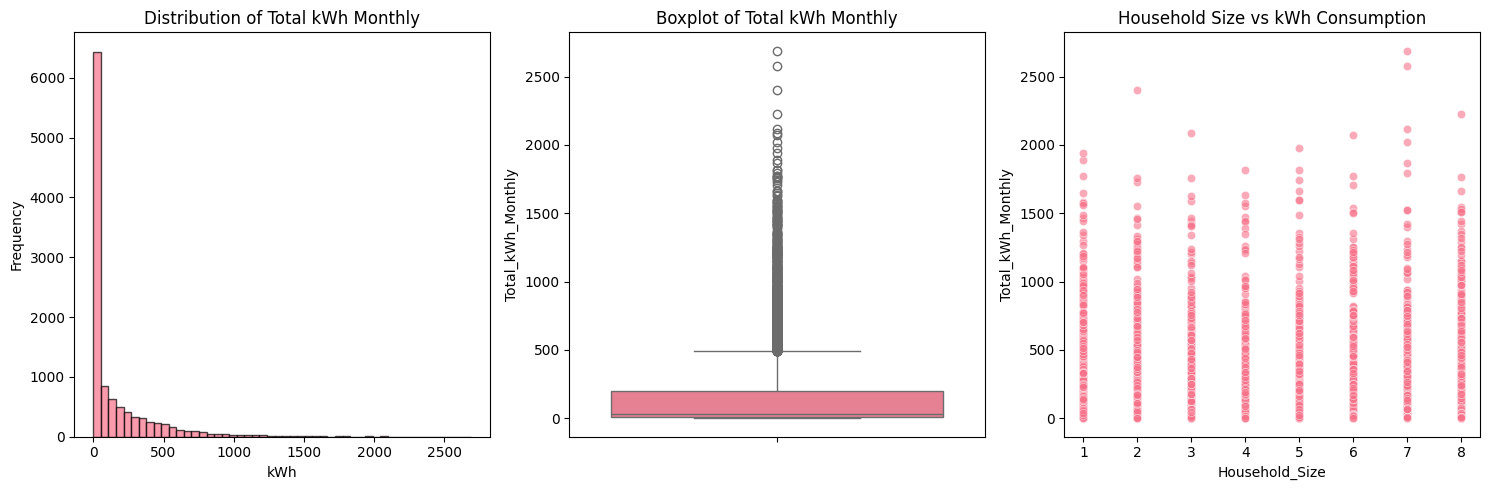

In [13]:
#  Data Exploration and Preprocessing
from IPython.display import display, Markdown

display(Markdown("##  DATA EXPLORATION"))

# Dataset info
display(Markdown(f"**Dataset info:** {df.shape[0]} rows × {df.shape[1]} columns"))

# Basic statistics
display(Markdown("###  Basic Statistics"))
display(df[['Total_kWh_Monthly', 'Household_Size', 'Income_Level']].describe())

# Missing values
display(Markdown("###  Missing Values"))
display(df.isnull().sum().to_frame("Missing_Count"))

# Unique values in categorical columns
display(Markdown("###  Unique Values in Categorical Columns"))
display(Markdown(f"- **Regions:** {', '.join(df['Region'].astype(str).unique())}"))
display(Markdown(f"- **Income Levels:** {', '.join(df['Income_Level'].astype(str).unique())}"))
display(Markdown(f"- **Tariff Brackets:** {', '.join(df['Tariff_Bracket'].astype(str).unique())}"))

# Visualization of Total_kWh_Monthly distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Total_kWh_Monthly'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Total kWh Monthly')
plt.xlabel('kWh')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Total_kWh_Monthly'])
plt.title('Boxplot of Total kWh Monthly')

plt.subplot(1, 3, 3)
sns.scatterplot(x=df['Household_Size'], y=df['Total_kWh_Monthly'], alpha=0.6)
plt.title('Household Size vs kWh Consumption')

plt.tight_layout()
plt.show()


=== FINDING OPTIMAL NUMBER OF CLUSTERS ===


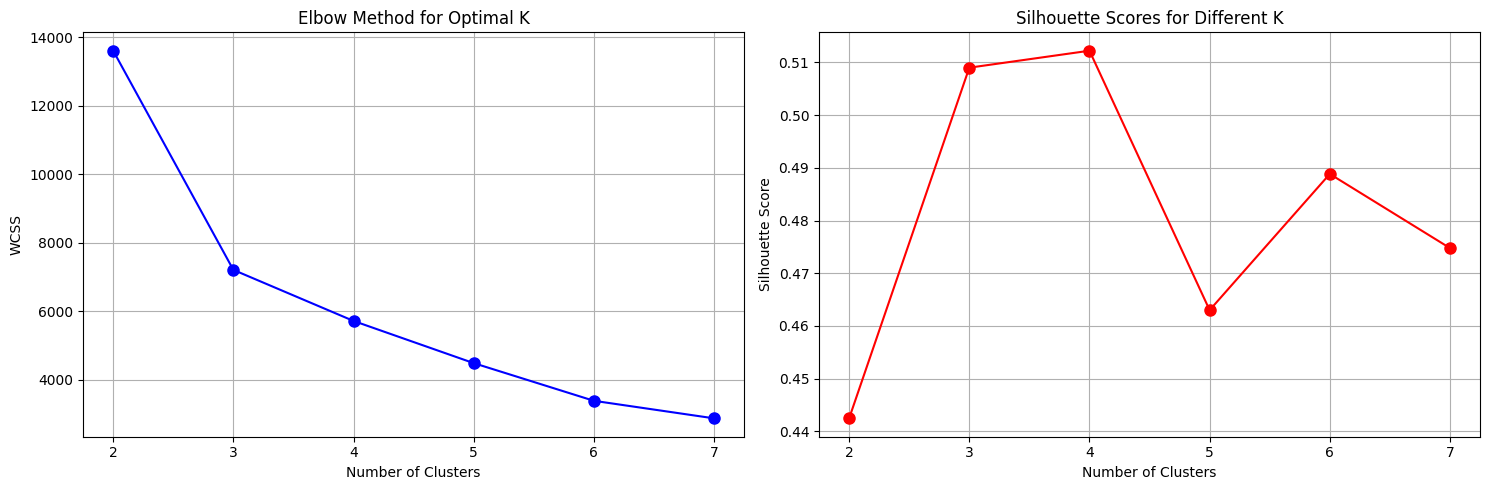

In [20]:
# CLUSTERING ANALYSIS - K-Means

# Prepare data for clustering
X_cluster = df[['Total_kWh_Monthly', 'Household_Size']].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using Elbow Method
print("=== FINDING OPTIMAL NUMBER OF CLUSTERS ===")
wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []

k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.grid(True)

plt.tight_layout()
plt.show()

# Apply K-Means with 3 clusters (as per your requirement)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df['Cluster'] = clusters

In [21]:
# RULE-BASED CLUSTERING (as per your specifications)

display(Markdown("## RULE-BASED CLUSTERING"))

def rule_based_clustering(kwh):
    if 20 <= kwh <= 99:
        return 'Tier 1: Small families'
    elif 100 <= kwh <= 250:
        return 'Tier 2: Average families'
    elif 300 <= kwh <= 600:
        return 'Tier 3: Large families'
    else:
        return 'Out of Range'

df['Rule_Based_Cluster'] = df['Total_kWh_Monthly'].apply(rule_based_clustering)

# Add Cluster_Label column
df['Cluster_Label'] = df['Cluster'].map({0: 'Tier 1', 1: 'Tier 2', 2: 'Tier 3'})

# Compare K-Means and Rule-Based clustering
display(Markdown("###  Cluster Distribution - K-Means"))
display(df['Cluster_Label'].value_counts().sort_index().to_frame("Count"))

display(Markdown("###  Cluster Distribution - Rule-Based"))
display(df['Rule_Based_Cluster'].value_counts().to_frame("Count"))

## RULE-BASED CLUSTERING

###  Cluster Distribution - K-Means

,Count
Cluster_Label,
Tier 1,4935
Tier 2,4830
Tier 3,1235


###  Cluster Distribution - Rule-Based

,Count
Rule_Based_Cluster,
Out of Range,5840
Tier 1: Small families,2347
Tier 2: Average families,1511
Tier 3: Large families,1302


##  CLUSTERING RESULTS

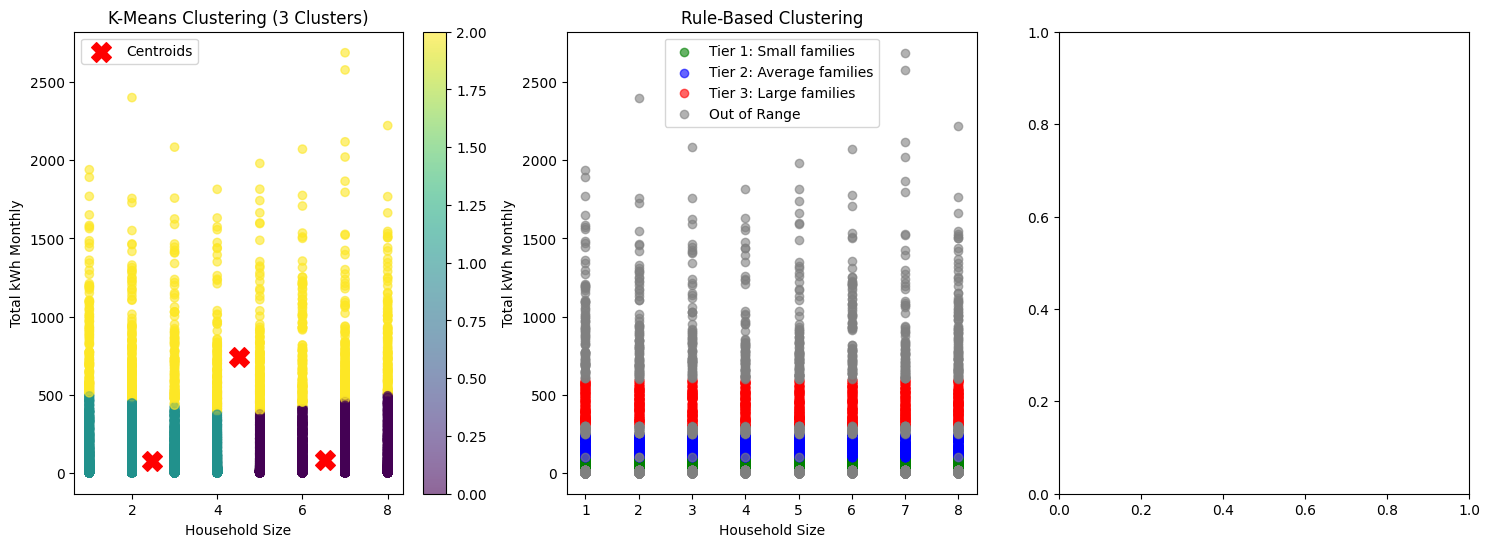

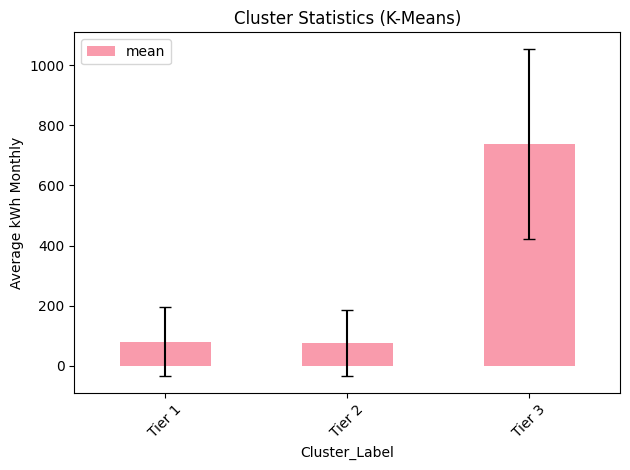

##  CLUSTER ANALYSIS

Total_kWh_Monthly                        Household_Size  \
                           mean     min      max count           mean   
Cluster_Label                                                           
Tier 1                    79.74    0.12   502.07  4935           6.52   
Tier 2                    76.35    0.10   498.30  4830           2.48   
Tier 3                   737.69  388.01  2689.20  1235           4.52   

              Income_Level   Region  
                  <lambda> <lambda>  
Cluster_Label                        
Tier 1                 Low  Eastern  
Tier 2                High  Eastern  
Tier 3                 Low  Eastern

In [22]:
# CLUSTERING VISUALIZATION AND ANALYSIS

display(Markdown("##  CLUSTERING RESULTS"))

# Create visualization
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
scatter = plt.scatter(
    df['Household_Size'], df['Total_kWh_Monthly'],
    c=df['Cluster'], cmap='viridis', alpha=0.6
)
plt.colorbar(scatter)
plt.xlabel('Household Size')
plt.ylabel('Total kWh Monthly')
plt.title('K-Means Clustering (3 Clusters)')

# Add cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='X', s=200, label='Centroids')
plt.legend()

# Rule-Based Clustering
plt.subplot(1, 3, 2)
colors = {
    'Tier 1: Small families': 'green',
    'Tier 2: Average families': 'blue',
    'Tier 3: Large families': 'red',
    'Out of Range': 'gray'
}
for tier, color in colors.items():
    mask = df['Rule_Based_Cluster'] == tier
    plt.scatter(
        df[mask]['Household_Size'], df[mask]['Total_kWh_Monthly'],
        c=color, label=tier, alpha=0.6
    )
plt.xlabel('Household Size')
plt.ylabel('Total kWh Monthly')
plt.title('Rule-Based Clustering')
plt.legend()

# Cluster comparison
plt.subplot(1, 3, 3)
cluster_stats = df.groupby('Cluster_Label')['Total_kWh_Monthly'].agg(['mean', 'std', 'count'])
cluster_stats.plot(kind='bar', y='mean', yerr='std', capsize=4, alpha=0.7)
plt.title('Cluster Statistics (K-Means)')
plt.ylabel('Average kWh Monthly')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Detailed cluster analysis
display(Markdown("##  CLUSTER ANALYSIS"))
cluster_analysis = df.groupby('Cluster_Label').agg({
    'Total_kWh_Monthly': ['mean', 'min', 'max', 'count'],
    'Household_Size': 'mean',
    'Income_Level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Region': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).round(2)

display(cluster_analysis)

In [23]:
# CLUSTERING METRICS

display(Markdown("##  CLUSTERING METRICS"))

# Calculate metrics for K-Means
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)

# Display results
display(Markdown("###  K-Means Clustering Metrics"))
display(Markdown(f"- **Silhouette Score:** {silhouette_avg:.4f}"))
display(Markdown(f"- **Calinski-Harabasz Index:** {calinski_harabasz:.4f}"))
display(Markdown(f"- **Davies-Bouldin Index:** {davies_bouldin:.4f}"))

# Interpretation
display(Markdown("###  Interpretation"))
display(Markdown("""
- **Silhouette Score (-1 to 1):** Higher is better (**> 0.5** indicates good separation)
- **Calinski-Harabasz Index:** Higher is better
- **Davies-Bouldin Index:** Lower is better (**< 1** indicates good clustering)
"""))


##  CLUSTERING METRICS

###  K-Means Clustering Metrics

- **Silhouette Score:** 0.5090

- **Calinski-Harabasz Index:** 11283.5254

- **Davies-Bouldin Index:** 0.7172

###  Interpretation


- **Silhouette Score (-1 to 1):** Higher is better (**> 0.5** indicates good separation)  
- **Calinski-Harabasz Index:** Higher is better  
- **Davies-Bouldin Index:** Lower is better (**< 1** indicates good clustering)


In [24]:
# ANOMALY DETECTION

display(Markdown("##  ANOMALY DETECTION"))

# Prepare data for anomaly detection
X_anomaly = df[['Total_kWh_Monthly', 'Household_Size', 'Usage_Hours_Daily', 'Quantity']].copy()

# Standardize features
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

# Method 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% anomalies
iso_predictions = iso_forest.fit_predict(X_anomaly_scaled)
df['IsolationForest_Anomaly'] = iso_predictions
df['IsolationForest_Anomaly_Label'] = df['IsolationForest_Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Method 2: Rule-Based (as per your specifications)
df['Rule_Based_Anomaly'] = df['Total_kWh_Monthly'].apply(
    lambda x: 'Anomaly' if x > 600 else 'Normal'
)

# Method 3: Local Outlier Factor (LOF)
lof = LocalOutlierFactor(contamination=0.05)
lof_predictions = lof.fit_predict(X_anomaly_scaled)
df['LOF_Anomaly'] = lof_predictions
df['LOF_Anomaly_Label'] = df['LOF_Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Display results
display(Markdown("###  Anomaly Detection Results"))
display(Markdown(f"- **Isolation Forest – Anomalies:** {(df['IsolationForest_Anomaly'] == -1).sum()}"))
display(Markdown(f"- **Rule-Based – Anomalies:** {(df['Rule_Based_Anomaly'] == 'Anomaly').sum()}"))
display(Markdown(f"- **Local Outlier Factor (LOF) – Anomalies:** {(df['LOF_Anomaly'] == -1).sum()}"))


##  ANOMALY DETECTION

###  Anomaly Detection Results

- **Isolation Forest – Anomalies:** 550

- **Rule-Based – Anomalies:** 686

- **Local Outlier Factor (LOF) – Anomalies:** 550

=== ANOMALY DETECTION ANALYSIS ===


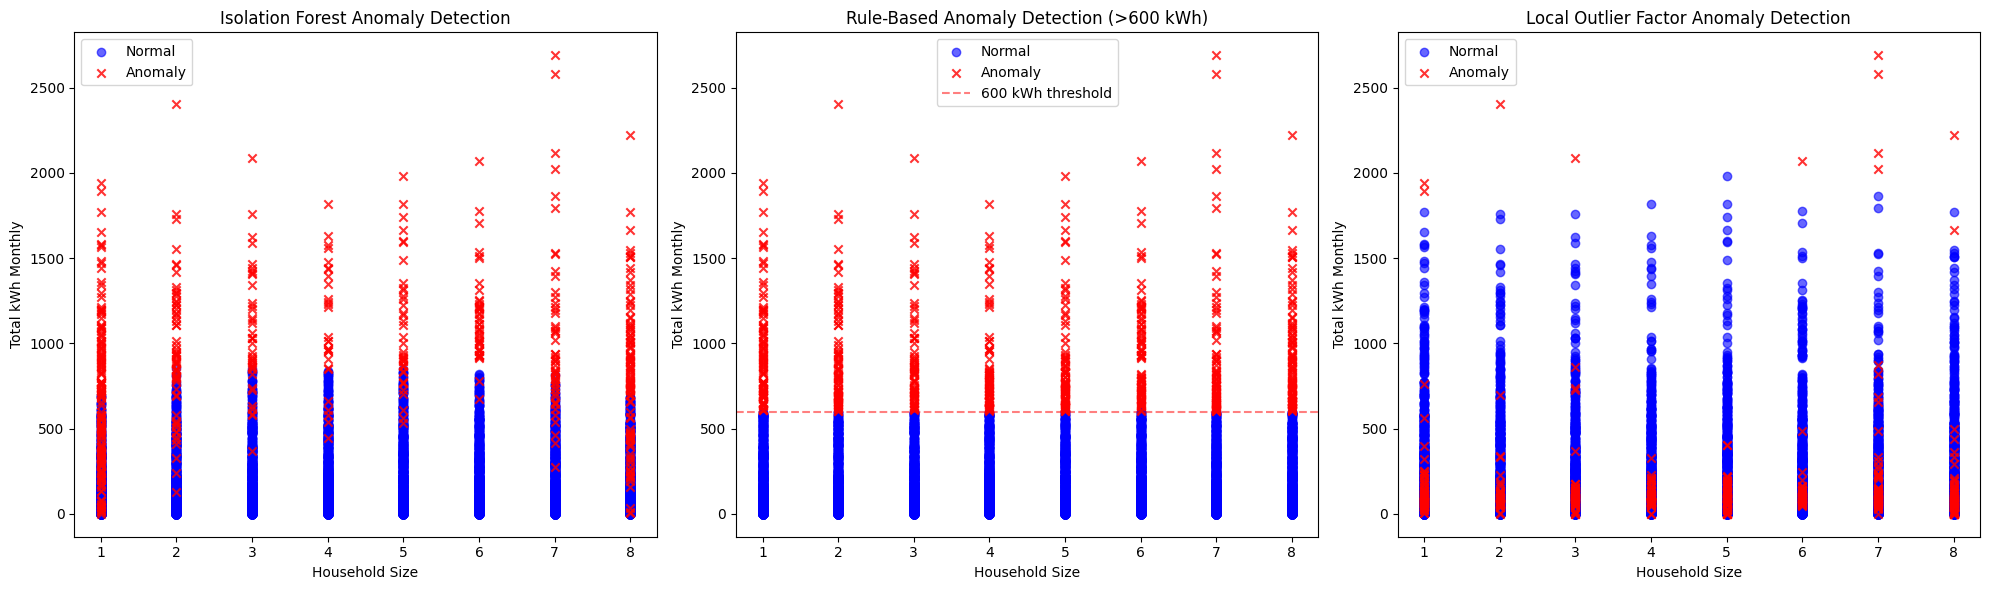

In [25]:
# ANOMALY DETECTION VISUALIZATION
print("=== ANOMALY DETECTION ANALYSIS ===")

plt.figure(figsize=(20, 6))

# Isolation Forest
plt.subplot(1, 3, 1)
normal_data = df[df['IsolationForest_Anomaly'] == 1]
anomaly_data = df[df['IsolationForest_Anomaly'] == -1]
plt.scatter(normal_data['Household_Size'], normal_data['Total_kWh_Monthly'],
           c='blue', alpha=0.6, label='Normal')
plt.scatter(anomaly_data['Household_Size'], anomaly_data['Total_kWh_Monthly'],
           c='red', alpha=0.8, label='Anomaly', marker='x')
plt.xlabel('Household Size')
plt.ylabel('Total kWh Monthly')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()

# Rule-Based
plt.subplot(1, 3, 2)
normal_data = df[df['Rule_Based_Anomaly'] == 'Normal']
anomaly_data = df[df['Rule_Based_Anomaly'] == 'Anomaly']
plt.scatter(normal_data['Household_Size'], normal_data['Total_kWh_Monthly'],
           c='blue', alpha=0.6, label='Normal')
plt.scatter(anomaly_data['Household_Size'], anomaly_data['Total_kWh_Monthly'],
           c='red', alpha=0.8, label='Anomaly', marker='x')
plt.axhline(y=600, color='red', linestyle='--', alpha=0.5, label='600 kWh threshold')
plt.xlabel('Household Size')
plt.ylabel('Total kWh Monthly')
plt.title('Rule-Based Anomaly Detection (>600 kWh)')
plt.legend()

# LOF
plt.subplot(1, 3, 3)
normal_data = df[df['LOF_Anomaly'] == 1]
anomaly_data = df[df['LOF_Anomaly'] == -1]
plt.scatter(normal_data['Household_Size'], normal_data['Total_kWh_Monthly'],
           c='blue', alpha=0.6, label='Normal')
plt.scatter(anomaly_data['Household_Size'], anomaly_data['Total_kWh_Monthly'],
           c='red', alpha=0.8, label='Anomaly', marker='x')
plt.xlabel('Household Size')
plt.ylabel('Total kWh Monthly')
plt.title('Local Outlier Factor Anomaly Detection')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# ANOMALY ANALYSIS AND METRICS

display(Markdown("##  DETAILED ANOMALY ANALYSIS"))

# Compare different anomaly detection methods
anomaly_comparison = pd.DataFrame({
    'Method': ['Isolation Forest', 'Rule-Based', 'Local Outlier Factor'],
    'Anomalies_Detected': [
        (df['IsolationForest_Anomaly'] == -1).sum(),
        (df['Rule_Based_Anomaly'] == 'Anomaly').sum(),
        (df['LOF_Anomaly'] == -1).sum()
    ],
    'Percentage': [
        f"{(df['IsolationForest_Anomaly'] == -1).sum() / len(df) * 100:.2f}%",
        f"{(df['Rule_Based_Anomaly'] == 'Anomaly').sum() / len(df) * 100:.2f}%",
        f"{(df['LOF_Anomaly'] == -1).sum() / len(df) * 100:.2f}%"
    ]
})

# Display comparison
display(Markdown("###  Anomaly Detection Comparison"))
display(anomaly_comparison)

# Analyze the detected anomalies
display(Markdown("##  ANOMALY CHARACTERISTICS"))

anomalies_iso = df[df['IsolationForest_Anomaly'] == -1]
anomalies_rule = df[df['Rule_Based_Anomaly'] == 'Anomaly']

display(Markdown("###  Isolation Forest Anomalies Statistics"))
display(anomalies_iso[['Total_kWh_Monthly', 'Household_Size', 'Income_Level', 'Region']].describe())

display(Markdown("###  Rule-Based Anomalies Statistics"))
display(anomalies_rule[['Total_kWh_Monthly', 'Household_Size', 'Income_Level', 'Region']].describe())

# Show some example anomalies
display(Markdown("##  EXAMPLE ANOMALIES DETECTED"))
display(Markdown("### Top 5 Rule-Based Anomalies (Highest Consumption)"))
display(
    anomalies_rule.nlargest(5, 'Total_kWh_Monthly')[
        ['Household_ID', 'Total_kWh_Monthly', 'Household_Size', 'Income_Level', 'Region']
    ]
)


##  DETAILED ANOMALY ANALYSIS

###  Anomaly Detection Comparison

,Method,Anomalies_Detected,Percentage
0,Isolation Forest,550,5.00%
1,Rule-Based,686,6.24%
2,Local Outlier Factor,550,5.00%


##  ANOMALY CHARACTERISTICS

###  Isolation Forest Anomalies Statistics

,Total_kWh_Monthly,Household_Size
count,550.000000,550.000000
mean,885.469255,4.192727
std,438.624989,2.805657
min,0.490000,1.000000
25%,578.185000,1.000000
50%,889.360000,4.000000
75%,1150.002500,7.000000
max,2689.200000,8.000000


###  Rule-Based Anomalies Statistics

,Total_kWh_Monthly,Household_Size
count,686.000000,686.000000
mean,919.813688,4.558309
std,322.080020,2.377869
min,600.170000,1.000000
25%,691.250000,2.000000
50%,806.820000,5.000000
75%,1057.492500,7.000000
max,2689.200000,8.000000


##  EXAMPLE ANOMALIES DETECTED

### Top 5 Rule-Based Anomalies (Highest Consumption)

,Household_ID,Total_kWh_Monthly,Household_Size,Income_Level,Region
772,HH00773,2689.20,7,High,Western
1030,HH01031,2579.04,7,Medium,Eastern
2821,HH02822,2401.92,2,Low,Kigali
6724,HH06725,2222.64,8,High,Kigali
64,HH00065,2118.87,7,High,Northern


In [27]:
# COMPREHENSIVE RESULTS SUMMARY

display(Markdown("##  COMPREHENSIVE ANALYSIS SUMMARY"))

#  Clustering Summary
display(Markdown("### 1.  CLUSTERING SUMMARY"))
display(Markdown(f"- **Total households analyzed:** {len(df)}"))
display(Markdown("- **K-Means clusters created:** 3"))
display(Markdown("- **Rule-based tiers applied:** 3"))

#  Anomaly Detection Summary
display(Markdown("### 2.  ANOMALY DETECTION SUMMARY"))
display(Markdown(
    f"- **Isolation Forest anomalies:** {(df['IsolationForest_Anomaly'] == -1).sum()} "
    f"({(df['IsolationForest_Anomaly'] == -1).sum() / len(df) * 100:.1f}%)"
))
display(Markdown(
    f"- **Rule-Based anomalies:** {(df['Rule_Based_Anomaly'] == 'Anomaly').sum()} "
    f"({(df['Rule_Based_Anomaly'] == 'Anomaly').sum() / len(df) * 100:.1f}%)"
))

#  Key Insights
display(Markdown("### 3.  KEY INSIGHTS"))

# Cluster insights
cluster_insights = df.groupby('Cluster_Label').agg({
    'Total_kWh_Monthly': 'mean',
    'Household_Size': 'mean'
}).round(2)

for cluster, data in cluster_insights.iterrows():
    display(Markdown(
        f"- **Cluster {cluster}:** Average consumption = {data['Total_kWh_Monthly']} kWh, "
        f"Average household size = {data['Household_Size']} members"
    ))

# High-consumption anomaly insights
high_consumption_anomalies = df[df['Total_kWh_Monthly'] > 1000]
if len(high_consumption_anomalies) > 0:
    display(Markdown(
        f"-  **High consumption:** Found {len(high_consumption_anomalies)} households with usage > 1000 kWh/month"
    ))


##  COMPREHENSIVE ANALYSIS SUMMARY

### 1.  CLUSTERING SUMMARY

- **Total households analyzed:** 11000

- **K-Means clusters created:** 3

- **Rule-based tiers applied:** 3

### 2.  ANOMALY DETECTION SUMMARY

- **Isolation Forest anomalies:** 550 (5.0%)

- **Rule-Based anomalies:** 686 (6.2%)

### 3.  KEY INSIGHTS

- **Cluster Tier 1:** Average consumption = 79.74 kWh, Average household size = 6.52 members

- **Cluster Tier 2:** Average consumption = 76.35 kWh, Average household size = 2.48 members

- **Cluster Tier 3:** Average consumption = 737.69 kWh, Average household size = 4.52 members

-  **High consumption:** Found 202 households with usage > 1000 kWh/month

## ADDITIONAL INSIGHTS

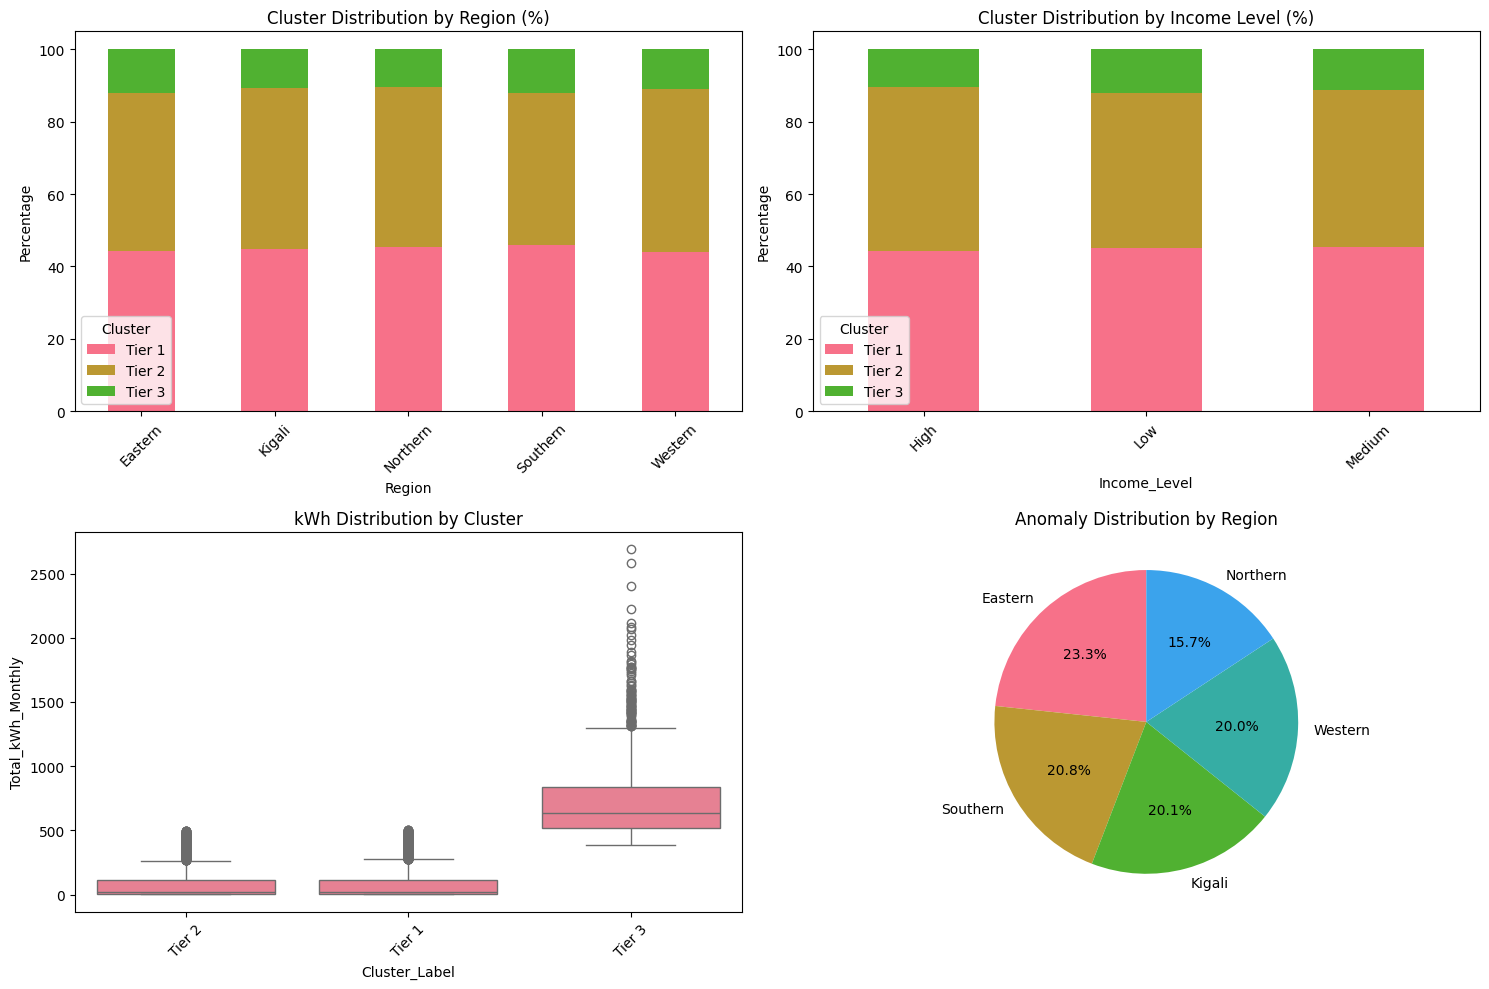

## FINAL SUMMARY STATISTICS

- **Overall Average Consumption:** 152.12 kWh

- **Overall Median Consumption:** 28.59 kWh

- **Maximum Consumption:** 2689.20 kWh

- **Minimum Consumption:** 0.10 kWh

In [28]:
# ADDITIONAL VISUALIZATIONS

display(Markdown("## ADDITIONAL INSIGHTS"))

# Regional and income-level analysis
plt.figure(figsize=(15, 10))

# Cluster distribution by region
plt.subplot(2, 2, 1)
region_cluster = pd.crosstab(df['Region'], df['Cluster_Label'], normalize='index') * 100
region_cluster.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Cluster Distribution by Region (%)')
plt.ylabel('Percentage')
plt.legend(title='Cluster')
plt.xticks(rotation=45)

# Cluster distribution by income level
plt.subplot(2, 2, 2)
income_cluster = pd.crosstab(df['Income_Level'], df['Cluster_Label'], normalize='index') * 100
income_cluster.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Cluster Distribution by Income Level (%)')
plt.ylabel('Percentage')
plt.legend(title='Cluster')
plt.xticks(rotation=45)

# kWh distribution by cluster
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Cluster_Label', y='Total_kWh_Monthly')
plt.title('kWh Distribution by Cluster')
plt.xticks(rotation=45)

# Anomaly distribution by region (pie chart)
plt.subplot(2, 2, 4)
anomaly_region = df[df['Rule_Based_Anomaly'] == 'Anomaly']['Region'].value_counts()
plt.pie(anomaly_region.values, labels=anomaly_region.index, autopct='%1.1f%%', startangle=90)
plt.title('Anomaly Distribution by Region')

plt.tight_layout()
plt.show()

# Final summary statistics
display(Markdown("## FINAL SUMMARY STATISTICS"))
display(Markdown(f"- **Overall Average Consumption:** {df['Total_kWh_Monthly'].mean():.2f} kWh"))
display(Markdown(f"- **Overall Median Consumption:** {df['Total_kWh_Monthly'].median():.2f} kWh"))
display(Markdown(f"- **Maximum Consumption:** {df['Total_kWh_Monthly'].max():.2f} kWh"))
display(Markdown(f"- **Minimum Consumption:** {df['Total_kWh_Monthly'].min():.2f} kWh"))
